# Features visualization

In [1]:
import seaborn as sns
import torch
import pandas as pd
import os
import warnings
import numpy as np
from tqdm import tqdm
warnings.filterwarnings("ignore")
from my_models import TransformerRegressionModel
import sys
sys.path.append("/code/LLM-crime")
from custom_clip_train import CLIPModel, CLIPDataset, build_loaders, make_prediction

In [34]:
from safety_perception_dataset import *
from collections import Counter

cfg_paras = {
    'size':(224,224),

    # safety perception
    'batch_size': 256,
    'variables_save_paths': f"/data2/cehou/LLM_safety/middle_variables/test",
    'safety_model_save_path' : f"/data2/cehou/LLM_safety/LLM_models/safety_perception_model/only_img/",
    'placepulse_datapath': "/data2/cehou/LLM_safety/PlacePulse2.0/image_perception_score.csv",
    'eval_path': "/data2/cehou/LLM_safety/eval/test/only_img/",
    'train_type': 'regression',
    'safety_epochs': 200,
    'class_num': 5,
    'CNN_lr': 1*1e-6,
    'weight_on': True
    }

data = pd.read_csv(cfg_paras['placepulse_datapath'])
data = data[data['Category'] == 'safety'].reset_index(drop=True).iloc[:]

# 计算每个类别的样本数量
data['label'] = data['Score'] * 100 // (100 / cfg_paras['class_num'])
label_counts = Counter(data['label'])
total_samples = len(data)
class_weights = [0 if label_counts[i] == 0 else total_samples / label_counts[i] for i in range(cfg_paras['class_num'])]
cfg_paras['class_weights'] = class_weights

# data['Score'] = (data['Score'] - data['Score'].min()) / (data['Score'].max() - data['Score'].min())

data_ls = data[data['Category'] == 'safety']
transform = get_transforms(cfg_paras['size'])
split_num = int(len(data_ls) * 0.7)

train_dataset = SafetyPerceptionDataset(data_ls[:split_num], transform=transform, paras=cfg_paras)
valid_dataset = SafetyPerceptionDataset(data_ls[split_num:split_num+256*4], transform=transform, paras=cfg_paras)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg_paras['batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cfg_paras['batch_size'])


In [8]:
from scipy.stats import normaltest
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

# Perform the normality test
stat, p_value = normaltest(data['Score'])
mu, std = norm.fit(data['Score'])


# Print the results
print(f'Statistic: {stat}, p-value: {p_value}')
print(f'mean: {mu}, std: {std}')

# Plot the distribution of 'Score'
# sns.histplot(data['Score'], kde=True)
# plt.title('Distribution of Scores')
# plt.xlabel('Score')
# plt.ylabel('Frequency')
# plt.show()

# Interpretation of the p-value
alpha = 0.05
if p_value > alpha:
    print('The null hypothesis cannot be rejected. The data follows a normal distribution.')
else:
    print('The null hypothesis is rejected. The data does not follow a normal distribution.')

Statistic: 4.135845277763515, p-value: 0.12644818760316665
mean: 4.908035747751228, std: 0.8614595168345961
The null hypothesis cannot be rejected. The data follows a normal distribution.


In [41]:
data.loc[:,'label'] = 0
data.loc[data[data['Score'] < mu - 0.5*std].index,'label'] = -1
data.loc[data[data['Score'] > mu + 0.5*std].index,'label'] = 1

/tmp/ipykernel_35450/2912791531.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'label'] = 0


In [46]:
# data.to_csv("/data2/cehou/LLM_safety/PlacePulse2.0/image_perception_score.csv",index=False)

In [36]:
from torchvision import models, transforms
import torch.nn as nn

class ResNet50FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet50FeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # 去掉最后的全连接层
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
    
    def forward(self, x):
        # 提取特征
        features = self.feature_extractor(x)
        # 展平特征为一维
        return features.view(features.size(0), -1)

model_path = f"/data2/cehou/LLM_safety/LLM_models/safety_perception_model/only_img/best_regression_model.pth"
# Load the model
model = ResNet50FeatureExtractor()
model.load_state_dict(torch.load(model_path), strict=False)
model.eval()

# Extract features from the validation loader
features = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        outputs = model(images)
        features.append(outputs)
        all_labels.append(labels)

# Convert the list of features to a tensor
features = torch.cat(features)
all_labels = torch.cat(all_labels)

100%|██████████| 4/4 [00:36<00:00,  9.24s/it]


In [4]:
from torchvision import models, transforms
import torch.nn as nn
from my_models import ResNet50Regressor

class ResNet50FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet50FeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # 去掉最后的全连接层
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
    
    def forward(self, x):
        # 提取特征
        features = self.feature_extractor(x)
        # 展平特征为一维
        return features.view(features.size(0), -1)

model_path = f"/data2/cehou/LLM_safety/LLM_models/safety_perception_model/only_img/best_regression_model.pth"
# Load the model
model = ResNet50Regressor(output_dim=1)
model.load_state_dict(torch.load(model_path))
model.eval()

# Extract features from the validation loader
features = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        outputs = model(images)
        features.append(outputs)
        all_labels.append(labels)

# Convert the list of features to a tensor
features = torch.cat(features)
all_labels = torch.cat(all_labels)

100%|██████████| 4/4 [00:37<00:00,  9.29s/it]


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Convert features and all_labels to numpy arrays
X = features.numpy()
y = all_labels.numpy()

# Initialize the linear regression model
reg_model = LinearRegression()

# Fit the model
reg_model.fit(X, y)

# Make predictions
y_pred = reg_model.predict(X)

# Calculate the mean squared error
mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate the R^2 score
r2 = r2_score(y, y_pred)
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.017539943844602692
R^2 Score: 0.0028319272269676787


In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# import seaborn as sns
# sns.heatmap(features.numpy())
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features.numpy(), all_labels.numpy(), test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)
# y_pred = rf_model.predict(X_test)

# Initialize the Support Vector Regressor
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

# Train the model
svr_model.fit(X_train, y_train)

# Make predictions
y_pred = svr_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.021278686511421015


R^2 Score: -0.0006730175393021565


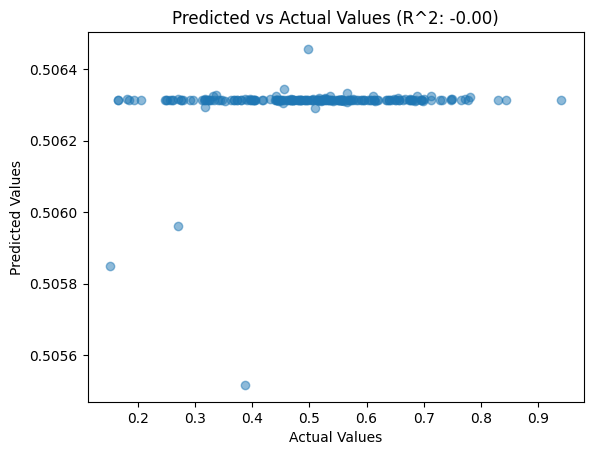

In [42]:
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
# Plot the predicted vs actual values
# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predicted vs Actual Values (R^2: {r2:.2f})')
plt.show()

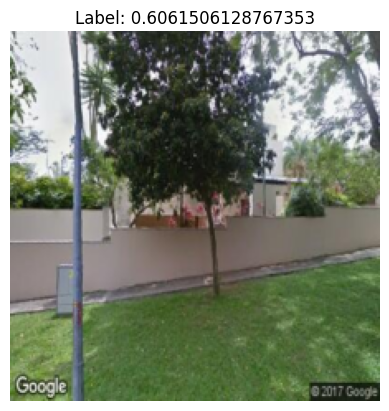

In [3]:
import matplotlib.pyplot as plt
# 获取第一个批次的数据
images, labels = next(iter(train_loader))

# 获取第一个图片和标签
first_image = images[12]
first_label = labels[12]

# 显示图片
plt.imshow(first_image.permute(1, 2, 0).numpy())
plt.title(f'Label: {first_label}')
plt.axis('off')
plt.show()

生成gif图

In [7]:
from PIL import Image
from glob import glob
import re


def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

pred_img_dir = glob(f"/data2/cehou/LLM_safety/eval/test/only_img/regression_plots/*")
pred_img_dir_sorted = sorted(pred_img_dir, key=natural_sort_key)


# Create a list to hold the images
images = []

# Iterate through the sorted image paths and open each image
for img_path in pred_img_dir_sorted:
    img = Image.open(img_path)
    images.append(img)

# Save the images as an animated GIF
images[0].save('/data2/cehou/LLM_safety/eval/test/only_img/gif/regression_plot_animated.gif',
               save_all=True, append_images=images[1:], duration=100, loop=0)


In [43]:
from PIL import Image
import re

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

# 创建一个空的图像列表
img_dir = glob('/data2/cehou/LLM_safety/eval/test/only_img/regression_plots/*')
img_dir_sorted = sorted(img_dir, key=natural_sort_key)
images = []

# 遍历图像路径列表并打开每个图像
for img_path in img_dir_sorted:  # 这里限制为前100张图像，你可以根据需要调整
    img = Image.open(img_path)
    images.append(img)

# 将图像保存为GIF
images[0].save('/data2/cehou/LLM_safety/eval/test/only_img/gif/regression_plot_animated.gif',
               save_all=True, append_images=images[1:], duration=100, loop=0)

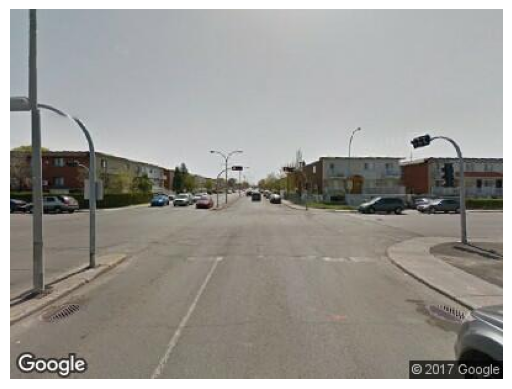

In [12]:
from PIL import Image

import matplotlib.pyplot as plt

# Read and display the image
image_path = '/data2/cehou/LLM_safety/PlacePulse2.0/photo_dataset/final_photo_dataset/5185d4d3fdc9f03fd500142e.jpg'
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [16]:
data_2.rename(columns={'Unnamed: 0': 'Image_ID'}, inplace=True)

In [29]:
for i, cate in enumerate(['beautiful','boring','depressing','lively','safety','wealthy']):
    data_2_tem = data_2[data_2[cate].notna()][['Image_ID', cate]].reset_index(drop=True)
    data_2_tem['Category'] = cate
    data_2_tem.rename(columns={cate: 'Score'}, inplace=True)
    print(f'{cate}: {len(data_2_tem)}')
    if i == 0:
        data2_out = data_2_tem
    else:
        data2_out = pd.concat([data2_out, data_2_tem], axis=0)    
        

beautiful: 7909
boring: 3395
depressing: 4967
lively: 15392
safety: 14396
wealthy: 7136


In [31]:
data2_out.to_csv("/data2/cehou/LLM_safety/PlacePulse2.0/image_perception_score.csv", index=False)

In [19]:
import torch
from collections import Counter

# 计算每个类别的样本数量
label_counts = Counter(data['label'])
total_samples = len(data)

In [20]:
label_counts

Counter({5.0: 3765,
         4.0: 4212,
         6.0: 859,
         3.0: 2588,
         1.0: 38,
         2.0: 450,
         7.0: 88})

In [36]:
class_weights = [0 if label_counts[i] == 0 else total_samples / label_counts[i] for i in range(10)]

In [41]:
class_weights

[0,
 315.7894736842105,
 26.666666666666668,
 4.636785162287481,
 2.849002849002849,
 3.187250996015936,
 13.969732246798603,
 136.36363636363637,
 0,
 0]

In [6]:
from safety_perception_dataset import SafetyPerceptionCLIPDataset

paras = {
    'train_type':'classification'
}
img_feature = np.load("/data2/cehou_data/LLM_safety/middle_variables/baseline/img_feature.npy")
data = pd.read_csv("/data2/cehou/LLM_safety/PlacePulse2.0/image_perception.csv")
train_dataset = SafetyPerceptionCLIPDataset(data, img_feature, paras)

In [10]:
aaa = pd.read_pickle("/data2/cehou_data/LLM_safety/img_text_data/dataset_baseline_baseline_baseline_baseline_501.pkl")
name_list = [aaa[i]['GSV_name'] for i in range(len(aaa))]

In [15]:
data[(data['Category'] == 'safety') & (data['Image_ID'].isin(name_list))].sort_values(by='Image_ID').reset_index(drop=True)

,Image_ID,Category,Q_Value
0,50e5f7d4d7c3df413b00056e,safety,0.490362
1,50e5f7d4d7c3df413b00056f,safety,0.335802
2,50e5f7d5d7c3df413b000571,safety,0.526509
3,50e5f7d5d7c3df413b000572,safety,0.456882
4,50e5f7d5d7c3df413b000573,safety,0.512934
...,...,...,...
496,50f42b7bfdc9f065f00013ae,safety,0.352735
497,50f42b7bfdc9f065f00013af,safety,0.533201
498,50f42b7bfdc9f065f00013b5,safety,0.551211
499,50f42b7bfdc9f065f00013b7,safety,0.569495


<Axes: >

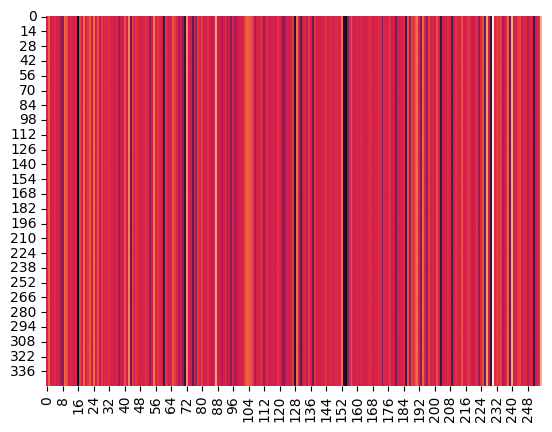

In [8]:
# show text in full
text_feature = np.load("/data2/cehou_data/LLM_safety/middle_variables/baseline/text_feature.npy")
sns.heatmap(text_feature[:,:], cbar=False)

[[1.0000001  0.9999871  0.9999769  ... 0.9999827  0.9999785  0.9999793 ]
 [0.9999871  1.0000001  0.9999841  ... 0.9999756  0.9999871  0.99998754]
 [0.9999769  0.9999841  1.0000002  ... 0.9999735  0.99998367 0.9999844 ]
 ...
 [0.9999827  0.9999756  0.9999735  ... 1.0000004  0.99996364 0.99996537]
 [0.9999785  0.9999871  0.99998367 ... 0.99996364 1.0000002  0.9999993 ]
 [0.9999793  0.99998754 0.9999844  ... 0.99996537 0.9999993  1.0000002 ]]


<Axes: >

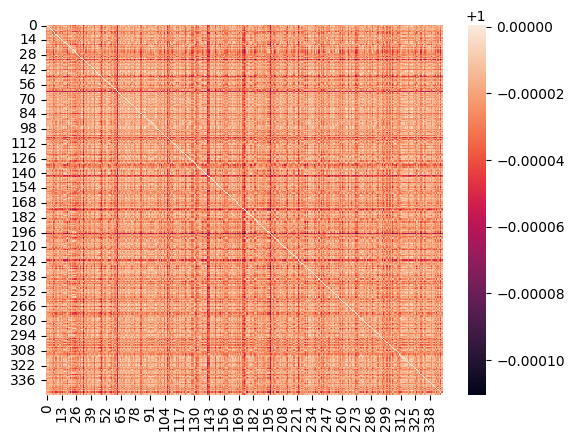

In [7]:
# 计算文本特征之间的余弦相似性
from sklearn.metrics.pairwise import cosine_similarity

text_similarity_matrix = cosine_similarity(text_feature)

# 打印相似性矩阵
print(text_similarity_matrix)
sns.heatmap(text_similarity_matrix)

## Make text short description

In [3]:
import pickle

def get_qa(text_description):
    answer = [i.split("<\\s> [INST]")[0] for i in text_description.split(" [/INST] ")][1:]
    question = [text_description.split(" [/INST] ")[0][7:]] + [i.split("<\\s> [INST]")[1] for i in text_description.split(" [/INST] ")[1:-1]]
    return answer, question

dataset = pd.read_pickle("/data2/cehou_data/LLM_safety/img_text_data/dataset_baseline_baseline_baseline_baseline_1401.pkl")

def text_processing(dataset_path, data_type):
    dataset = pd.read_pickle(dataset_path)
    text_description = [dataset[i]['text_description'] for i in range(len(dataset))]

    answer_list = [get_qa(text_description[i])[0] for i in range(len(text_description))]
    question_list = [get_qa(text_description[i])[1] for i in range(len(text_description))]
    if data_type == 'baseline':
        text_description_new = [answer_list[i][1] for i in range(len(text_description))]
        for i in range(len(dataset)):
            dataset[i]['text_description_short'] = text_description_new[i]
    else:
        print('not implemented')

    with open(dataset_path, 'wb') as f:
        pickle.dump(dataset, f)
    return None

text_processing("/data2/cehou_data/LLM_safety/img_text_data/dataset_baseline_baseline_baseline_baseline_1401.pkl", 'baseline')

In [6]:
example_data_path = pd.read_pickle("/data2/cehou/LLM_safety/dataset_30_female_HongKong_murder_746.pkl")
text_data = [example_data_path[i]['text_description'] for i in range(len(example_data_path))]

In [7]:
answer = [i.split("<\\s> [INST]")[0] for i in text_data[0].split(" [/INST] ")][1:]
question = [text_data[0].split(" [/INST] ")[0][7:]] + [i.split("<\\s> [INST]")[1] for i in text_data[0].split(" [/INST] ")[1:-1]]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 定义两个字符串

def cal_text_similarity(str_list):
    # 将文本转换为tf-idf特征
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(str_list)
    # 计算两个字符串之间的余弦相似度
    similarity = cosine_similarity(tfidf)
    return similarity

sim_mat_a = cal_text_similarity(answer)
sim_mat_q = cal_text_similarity(question)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(9,4))

sns.heatmap(sim_mat_a, annot=True,vmin=0,vmax=1, ax=ax[0])
sns.heatmap(sim_mat_q, annot=True,vmin=0,vmax=1, ax=ax[1])

In [20]:
# 获取对角线以上的矩阵部分
upper_triangle_sim_mat_q = np.triu(sim_mat_q, k=1)
upper_triangle_sim_mat_a = np.triu(sim_mat_a, k=1)

In [25]:
upper_triangle_sim_mat_a_list = upper_triangle_sim_mat_a[np.triu_indices(upper_triangle_sim_mat_a.shape[0], k=1)].tolist()
upper_triangle_sim_mat_q_list = upper_triangle_sim_mat_q[np.triu_indices(upper_triangle_sim_mat_q.shape[0], k=1)].tolist()

In [ ]:
plt.scatter(upper_triangle_sim_mat_q_list, upper_triangle_sim_mat_a_list)

In [170]:
cfg = 'baseline'
img_feature = np.load(f"/data2/cehou_data/LLM_safety/middle_variables/{cfg}/img_feature.npy")
text_feature = np.load(f"/data2/cehou_data/LLM_safety/middle_variables/{cfg}/text_feature.npy")
predictions = np.load(f"/data2/cehou_data/LLM_safety/middle_variables/{cfg}/predictions.npy")


In [171]:
from sklearn.metrics.pairwise import cosine_similarity

# 计算文本特征之间的余弦相似性
text_feature_similarity = cosine_similarity(text_feature)
img_feature_similarity = cosine_similarity(img_feature)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(text_feature[:10,:10])

## 计算文本间相似性


In [173]:
if cfg == 'baseline':
    data = pd.read_pickle(f"/data2/cehou_data/LLM_safety/dataset_baseline_746.pkl")
else:
    data = pd.read_pickle(f"/data2/cehou_data/LLM_safety/dataset_30_{cfg}_HongKong_murder_746.pkl")
text_describe_list = [data[i]['text_description'] for i in range(len(data))]

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 定义两个字符串

def cal_text_similarity(str_list):
    # 将文本转换为tf-idf特征
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(str_list)
    # 计算两个字符串之间的余弦相似度
    similarity = cosine_similarity(tfidf)
    return similarity

text_similarity = cal_text_similarity(text_describe_list)

In [175]:
# 获取对角线以上上半部分的元素及其位置
upper_triangle_indices = np.triu_indices(text_similarity.shape[0], k=1)
upper_triangle_values = text_similarity[upper_triangle_indices]

# 记录位置
positions = list(zip(upper_triangle_indices[0], upper_triangle_indices[1]))

In [176]:
from PIL import Image
def get_img(dataset, idx):
    for i,path in enumerate(dataset[idx]["GSV_path"]):
        if i == 0:
            GSV_img = np.array(Image.open(path))
        else:
            GSV_img = np.concatenate((GSV_img, np.array(Image.open(path))), axis=1)
    return GSV_img

def cal_img_similarity(dataset, img1_idx, img2_idx):
    img1 = get_img(dataset, img1_idx)
    img2 = get_img(dataset, img2_idx)
    img1_flat = img1.flatten().reshape(1, -1)
    img2_flat = img2.flatten().reshape(1, -1)
    img_similarity = cosine_similarity(img1_flat, img2_flat)
    return img_similarity[0][0]

In [177]:
evaluation_df = pd.DataFrame(columns=['img1_idx', 'img2_idx', 'config', 'text_similarity', 'img_similarity','text_feature_similarity','img_feature_similarity'])
for i in range(25):
    for j in range(25):
        if i < j:
            img_similarity = cal_img_similarity(data, i, j)
            evaluation_df = evaluation_df.append({'img1_idx': i, 'img2_idx': j, 'config':cfg, 'text_similarity': text_similarity[i][j], 'img_similarity': img_similarity, 'text_feature_similarity': text_feature_similarity[i][j], 'img_feature_similarity': img_feature_similarity[i][j]}, ignore_index=True)            
            
evaluation_df.to_csv(f"/data2/cehou_data/LLM_safety/middle_variables/{cfg}/evaluation_df.csv", index=False)

In [ ]:

# 计算相关系数
correlation = np.corrcoef(evaluation_df['text_similarity'], evaluation_df['img_similarity'])[0, 1]

sns.regplot(x='text_similarity', y='img_similarity', data=evaluation_df)
# 标记相关系数
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

In [ ]:
correlation = np.corrcoef(evaluation_df['text_feature_similarity'], evaluation_df['img_feature_similarity'])[0, 1]

sns.regplot(x='text_feature_similarity', y='img_feature_similarity', data=evaluation_df)
# 标记相关系数
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 计算文本特征之间的余弦相似性
text_similarity_matrix = cosine_similarity(text_feature)

# 打印相似性矩阵
print(text_similarity_matrix)
sns.heatmap(text_similarity_matrix)

In [ ]:
for i,cfg in enumerate(['male','female','baseline']):
    data = pd.read_csv(f"/data2/cehou_data/LLM_safety/middle_variables/{cfg}/evaluation_df.csv")
    if i == 0:
        all_data = data
    else:
        all_data = pd.concat([all_data, data], axis=0, ignore_index=True)

In [ ]:
sns.scatterplot(
   x="text_similarity",
   y="img_similarity",
   data=all_data,
   hue='config',
)